<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>Exercise 6: Spatial Autocorrelation</h2>
<h3>IT University of Copenhagen, Spring 2024</h3>
<h3>Instructor: Ditte Stavski</h3>
</div>

This notebook was adapted from:
* A course on geographic data science: https://darribas.org/gds_course/content/bF/diy_F.html

## Data preparation

In this exercise we will try to detect *spatial autocorrelation* in the voting behaviour in Denmark.
The dataset is from the parliament election in 2022 on the most detailed spatial resolution called 'afstemningsområder' (*voting areas*) (similar to the polygon data set that we used in lecture 4!)

You can find the necessary data in the data subfolder. Read more about the data on the data source: https://valgdatabase.dst.dk/

The data set with number of votes for each party in each area does not include the geometries for the area.
To plot the election data with the geometries you therefore first need to join the them with a spatial dataset of all voting areas in DK.

The dataset with the geometries is from https://dataforsyningen.dk/ (a very good source to public spatial data in DK).

## Task I: Get the data ready!

To join the two datasets you need to use the columns 'ValgstedId' in the two files.

Since there are no geometries in the csv-data, there is no need to reproject the data before joining - but it is still good practice to check the crs and see if it is the one we want.
In our case the data is in a specific version of the UTM crs usually used for Denmark.

When the data are ready, complete all the other parts required for the ESDA analysis of spatial autocorrelation:

- Make sure your geography does not have islands (either by removing them or using a method which does not create islands in our data set)
- Create a spatial weights matrix
- Standardise the spatial weights matrix
- Create a standardised version of the data/column you are working with
- Create the spatial lag of the number of votes in the voting areas

**When creating your spatial weights matrix, think of one criterium to build it that you think would fit this variable (e.g. contiguity, distance-based, etc.), and apply it.**

**The data set on votes in each area contains columns with votes for each party, number of people entitled to vote, etc. You have to choose yourself which part of the data you want to do your analysis on. It might be a good idea to convert all total numbers to percentage.**


In [1]:
import seaborn as sns
import pandas as pd
import esda
from pysal.lib import weights
from splot.esda import (
    plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation,
)
from splot.libpysal import plot_spatial_weights
import geopandas as gpd
import numpy as np
import contextily as cx
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [2]:
# Filepaths

fp_votes = './data/election_data.csv'
fp_geom = './data/voting_areas.gpkg'

In [3]:
votes = pd.read_csv(fp_votes, delimiter=';')
areas = gpd.read_file(fp_geom)
gdf = areas.merge(votes, on='ValgstedId')

In [4]:
w = weights.DistanceBand.from_dataframe(gdf, 10000)

In [5]:
#f, ax = plt.subplots()
#gdf.plot(ax=ax)
#gdf.centroid.buffer(10000).plot(ax=ax, facecolor='none')

In [6]:
len(w.islands)

17

<AxesSubplot:>

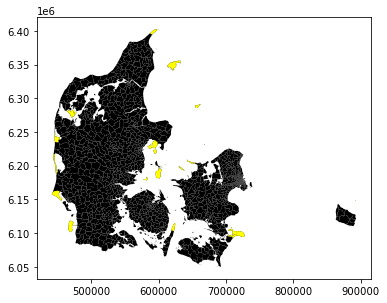

In [7]:
f, ax = plt.subplots(figsize=(6,6))
gdf.plot(color='black', ax=ax)
gdf.loc[w.islands].plot(color='yellow', ax=ax)

In [8]:
# nuke islands
gdf = gdf.drop(w.islands)

In [10]:
w = weights.DistanceBand.from_dataframe(gdf, 10000)

In [11]:
# standardize rows
w.transform = 'R'

In [12]:
gdf['ratio'] = gdf['FV2022 - Æ. Danmarksdemokraterne - Inger Støjberg'] / gdf['FV2022 - Afgivne stemmer']

# standardize target column
col = 'ratio'
gdf['x'] = (gdf[col] - gdf[col].mean()) / gdf[col].std()

In [13]:
gdf['x_lag'] = weights.lag_spatial(w, gdf.x)

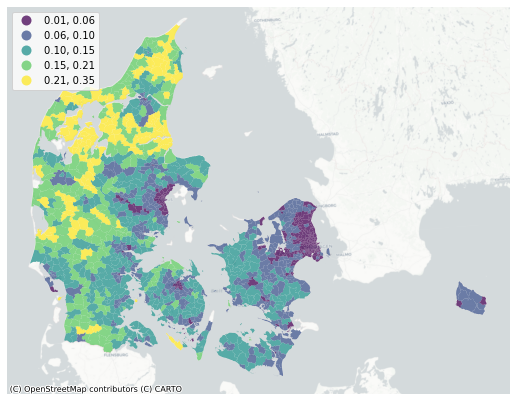

In [14]:
f, ax = plt.subplots(figsize=(9, 9))
gdf.plot(
    column=col,
    cmap="viridis",
    scheme="FisherJenks",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax,
)
cx.add_basemap(
    ax,
    crs=gdf.crs,
    source=cx.providers.CartoDB.Positron
)
ax.set_axis_off()
f.savefig('DANNEBROG.svg')

## Task II: Global spatial autocorrelation

Let's move on to the analytics:

- Visualise your data score with a Moran Plot
- Calculate Moran's I
- **What conclusions can you reach from the Moran Plot and Moran's I? What is the main spatial pattern?**

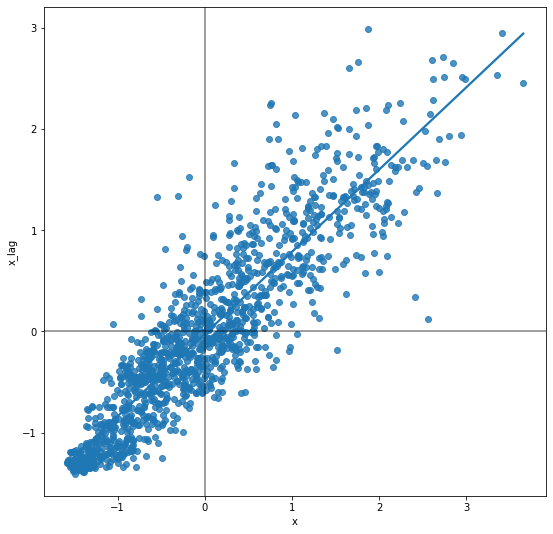

In [15]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='x', y='x_lag', data=gdf, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

In [16]:
mi = esda.Moran(gdf['x'], w)

In [17]:
mi.I, mi.p_sim

(0.8112112100535326, 0.001)

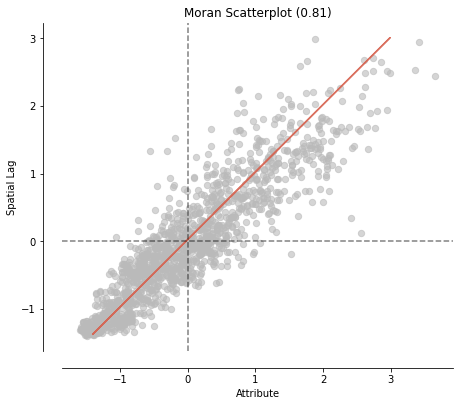

In [18]:
moran_scatterplot(mi);

## Task III: Local spatial autocorrelation

Now that you have a good sense of the overall pattern in the dataset, let's move to the local scale:

1. Calculate LISA (Local Indicators of Spatial Association) statistics for the voting areas using a variable of your choice.
    - **How many of the voting areas have a significant LISA value at p=0.05?**
2. Use a KDE plot to inspect the distribution of LISA values. 
    - **Can you say something about the general pattern from this alone?**
3. How many voting areas are in each of the four quadrants, at p=0.05? (low-low, high-high, high-low, low-low)
3. Make a map of significant clusters at the 5%.
    - **Can you identify hotspots or coldspots? If so, what do they mean? What about spatial outliers?**
4. Create cluster maps for significance levels 0.5, 1% and 5% and compare them. 
    - **What are the main changes? Why?**
5. **Do the results confirm your impression of voting patterns in Denmark?**

**TIPS:**

- esda.Moran_Local() returns an object with several attributes! See: https://pysal.org/esda/generated/esda.Moran_Local.html 

- splot.esda.lisa_cluster takes the p-value as parameter! (default: 5%): https://splot.readthedocs.io/en/latest/generated/splot.esda.lisa_cluster.html

- `lisa.q` (if lisa is the object returned by esda.Moran_Local()) returns the quadrant of each object - but without considering the significance

In [19]:
lisa = esda.Moran_Local(gdf.x, w)

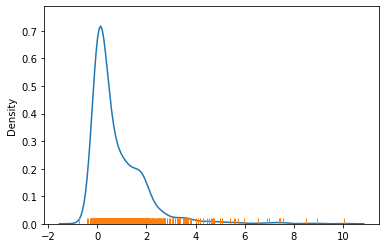

In [20]:
# Draw KDE line
ax = sns.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
sns.rugplot(lisa.Is, ax=ax);

In [21]:
# Break observations into significant or not
gdf['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
gdf['quadrant'] = lisa.q

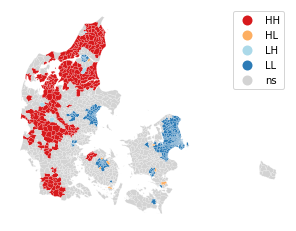

In [22]:
lisa_cluster(lisa, gdf, p=0.05); # the vaue for p changes the significance threshold used in the plot

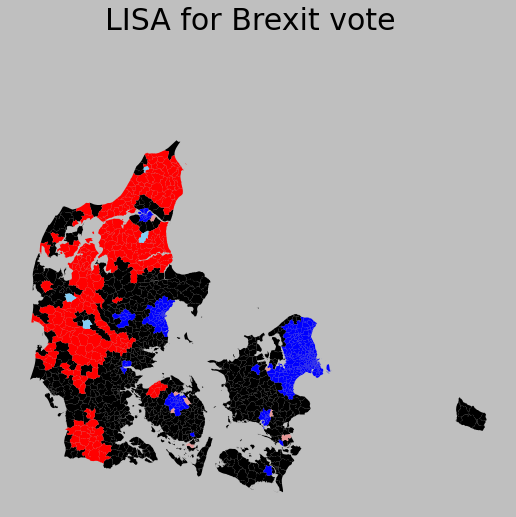

In [23]:
br = gdf

# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot insignificant clusters
ns = br.loc[br['significant']==False, 'geometry']
ns.plot(ax=ax, color='k')
# Plot HH clusters
hh = br.loc[(br['quadrant']==1) & (br['significant']==True), 'geometry']
hh.plot(ax=ax, color='red')
# Plot LL clusters
ll = br.loc[(br['quadrant']==3) & (br['significant']==True), 'geometry']
ll.plot(ax=ax, color='blue')
# Plot LH clusters
lh = br.loc[(br['quadrant']==2) & (br['significant']==True), 'geometry']
lh.plot(ax=ax, color='#83cef4')
# Plot HL clusters
hl = br.loc[(br['quadrant']==4) & (br['significant']==True), 'geometry']
hl.plot(ax=ax, color='#e59696')
# Style and draw
f.suptitle('LISA for Brexit vote', size=30)
f.set_facecolor('0.75')
ax.set_axis_off()
plt.show()